# Failure: not all code is faster

Let's look at a problem that is slower on a GPU when you convert to CuPy. This is a simple ODE solver.

## Classic NumPy code

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x_max = 1  # Size of x max
v_0 = 0
koverm = 1  # k / m

In [2]:
def f(t, y):
    "Y has two elements, x and v"
    return np.array([-koverm * y[1], y[0]])


def euler_ivp(f, init_y, t):
    steps = len(t)
    order = len(init_y)  # Number of equations

    y = np.empty((steps, order))
    y[0] = init_y  # Note that this sets the elements of the first row

    for n in range(steps - 1):
        h = t[n + 1] - t[n]

        # Copute dydt based on *current* position
        dydt = f(t[n], y[n])

        # Compute next velocity and position
        y[n + 1] = y[n] - dydt * h

    return y

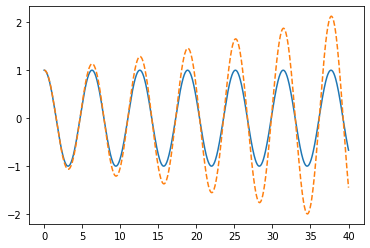

In [5]:
ts = np.linspace(0, 40, 1000 + 1)
y = euler_ivp(f, [x_max, v_0], ts)
plt.plot(ts, np.cos(ts))
plt.plot(ts, y[:, 0], "--")

In [6]:
%%timeit
y = euler_ivp(f, [x_max, v_0], ts)

3.07 ms ± 48.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## CuPy

In [50]:
import cupy as cp
import cupyx

In [18]:
def f(t, y):
    "Y has two elements, x and v"
    #xp = cp.get_array_module(t)
    return cp.array([-koverm * y[1], y[0]])


def euler_ivp(f, init_y, t):
    #xp = cp.get_array_module(t)
    steps = len(t)
    order = len(init_y)  # Number of equations

    y = cp.empty((steps, order))
    y[0] = init_y  # Note that this sets the elements of the first row

    for n in range(steps - 1):
        h = t[n + 1] - t[n]

        # Copute dydt based on *current* position
        dydt = f(t[n], y[n])

        # Compute next velocity and position
        y[n + 1] = y[n] - dydt * h

    return y

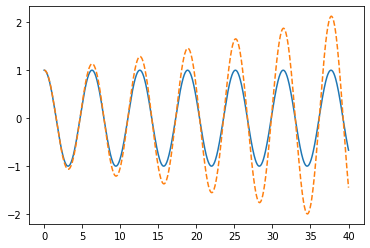

In [19]:
ts = cp.linspace(0, 40, 1000 + 1)
y = euler_ivp(f, cp.array([x_max, v_0]), ts)
plt.plot(ts.get(), np.cos(ts).get())
plt.plot(ts.get(), y[:, 0].get(), "--")

In [20]:
%%timeit
y = euler_ivp(f, cp.array([x_max, v_0]), ts)

78.7 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
def f(t, y):
    "Y has two elements, x and v"
    return -koverm * y[1], y[0]


def euler_ivp(f, init_y, t):
    steps = len(t)
    order = len(init_y)  # Number of equations (2)

    y = cp.empty((steps, order))
    y[0] = init_y  # Note that this sets the elements of the first row

    for n in range(steps - 1):
        h = t[n + 1] - t[n]

        # Copute dydt based on *current* position
        dydt_0, dydt_1 = f(t[n], y[n])

        # Compute next velocity and position
        y[n + 1, 0] = y[n,0] - dydt_0 * h
        y[n + 1, 1] = y[n,1] - dydt_1 * h

    return y

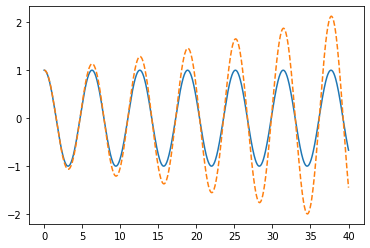

In [22]:
ts = cp.linspace(0, 40, 1000 + 1)
y = euler_ivp(f, cp.array([x_max, v_0]), ts)
plt.plot(ts.get(), np.cos(ts).get())
plt.plot(ts.get(), y[:, 0].get(), "--")

In [23]:
%%timeit
y = euler_ivp(f, cp.array([x_max, v_0]), ts)

63.1 ms ± 158 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
